In [1]:
path = "/kaggle/input/utkface-new/UTKFace"

In [2]:
import os
files = os.listdir(path)
len(files)

23708

In [3]:
age, gender, img_path = [], [], []

for i in files:
    parts = i.split('_')
    age.append(int(parts[0]))
    gender.append(int(parts[1]))
    img_path.append(i)
    

In [4]:
import pandas as pd

df = pd.DataFrame({"age":age, "gender":gender, "img_name":img_path})
df.tail()

,age,gender,img_name
23703,41,0,41_0_0_20170109012220690.jpg.chip.jpg
23704,42,0,42_0_0_20170117185738076.jpg.chip.jpg
23705,2,0,2_0_2_20161219221701671.jpg.chip.jpg
23706,65,1,65_1_0_20170110182002744.jpg.chip.jpg
23707,66,0,66_0_1_20170117195116702.jpg.chip.jpg


In [5]:
df.describe()

,age,gender
count,23708.000000,23708.000000
mean,33.303484,0.477349
std,19.886112,0.499497
min,1.000000,0.000000
25%,23.000000,0.000000
50%,29.000000,0.000000
75%,45.000000,1.000000
max,116.000000,1.000000


In [6]:
female = (df["gender"]==1).sum()
male = (df["gender"]==0).sum()

female, male

(11317, 12391)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: >

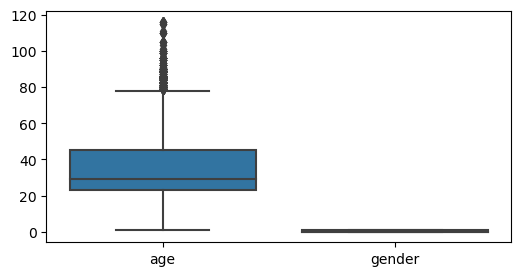

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=[6, 3])
sns.boxplot(df)

<Axes: xlabel='age', ylabel='Count'>

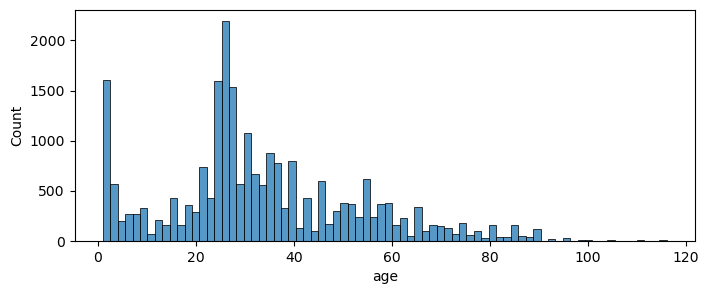

In [8]:
plt.figure(figsize=[8, 3])
sns.histplot(df["age"])

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.2, random_state=32)

In [10]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)


test_datagen = ImageDataGenerator(
    rescale=1/255,
)


train_ds = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=path,
    x_col="img_name",    
    y_col=["age", "gender"], 
    target_size=(100, 100),
    batch_size=32,
    class_mode="multi_output",
)

test_ds = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=path,
    x_col="img_name",
    y_col=["age", "gender"],
    target_size=(100, 100),
    batch_size=32,
    class_mode="multi_output",
)

Found 18966 validated image filenames.
Found 4742 validated image filenames.


In [12]:
from keras.layers import *
from keras.models import Model
from keras.optimizers import *
from keras.losses import *

In [13]:
input_layer = Input(shape =(100, 100, 3))

conv1 = Conv2D(64, kernel_size=(3,3), padding="valid", activation="relu")(input_layer)
pool1 = MaxPooling2D(pool_size=(2,2), strides=None, padding="valid")(conv1)

conv2 = Conv2D(128, kernel_size=(3,3), padding="valid", activation="relu")(pool1)
pool2 = MaxPooling2D(pool_size=(2,2), strides=None, padding="valid")(conv2)

flatten =  Flatten()(pool2)

dense1 = Dense(units = 256, activation = "relu")(flatten)
dense2 = Dense(units = 256, activation = "relu")(dense1)

dense3 = Dense(units = 256, activation = "relu")(dense2)
dense4 = Dense(units = 256, activation = "relu")(dense3)

output1 = Dense(units=1, activation = "linear", name="age")(dense3)
output2 = Dense(units = 1, activation= "sigmoid", name="gender")(dense4)

model = Model(inputs = input_layer, outputs=[output1, output2])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 98, 98, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 49, 49, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 47, 47, 128)  73856       ['max_pooling2d[0][0]']      

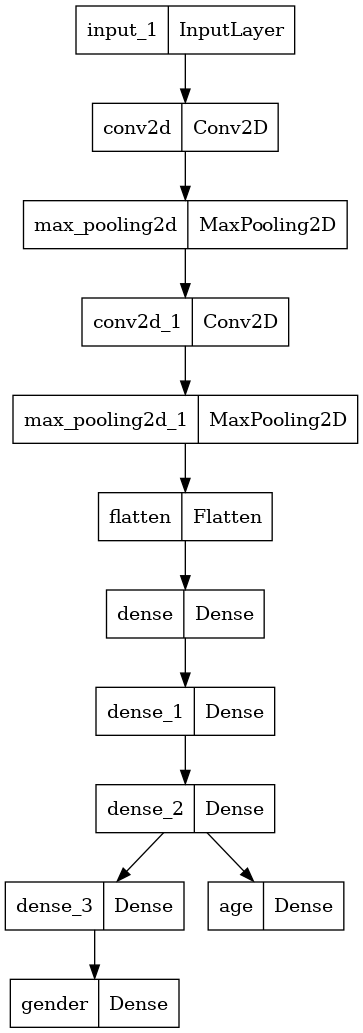

In [14]:
from keras.utils import plot_model
plot_model(model)

In [15]:
model.compile(
    optimizer=Adam(), 
    loss={"age": MeanSquaredError(), "gender" :BinaryCrossentropy()},
    metrics={"age": MeanSquaredError(), "gender": "accuracy"},
)

In [16]:
hist = model.fit(
    train_ds,
    epochs = 5,
    batch_size=10,
    validation_data=test_ds)

Epoch 1/5
593/593 [==============================] - 184s 297ms/step - loss: 396.2072 - age_loss: 395.4889 - gender_loss: 0.7183 - age_mean_squared_error: 395.5121 - gender_accuracy: 0.5444 - val_loss: 376.7814 - val_age_loss: 376.1231 - val_gender_loss: 0.6584 - val_age_mean_squared_error: 375.0394 - val_gender_accuracy: 0.5962
Epoch 2/5
593/593 [==============================] - 84s 142ms/step - loss: 349.5922 - age_loss: 348.8969 - gender_loss: 0.6955 - age_mean_squared_error: 348.8299 - gender_accuracy: 0.5941 - val_loss: 289.6912 - val_age_loss: 289.0562 - val_gender_loss: 0.6350 - val_age_mean_squared_error: 288.4223 - val_gender_accuracy: 0.6242
Epoch 3/5
593/593 [==============================] - 86s 144ms/step - loss: 330.7232 - age_loss: 330.0518 - gender_loss: 0.6715 - age_mean_squared_error: 330.0510 - gender_accuracy: 0.6032 - val_loss: 262.3129 - val_age_loss: 261.6349 - val_gender_loss: 0.6779 - val_age_mean_squared_error: 260.5513 - val_gender_accuracy: 0.5839
Epoch 4/5

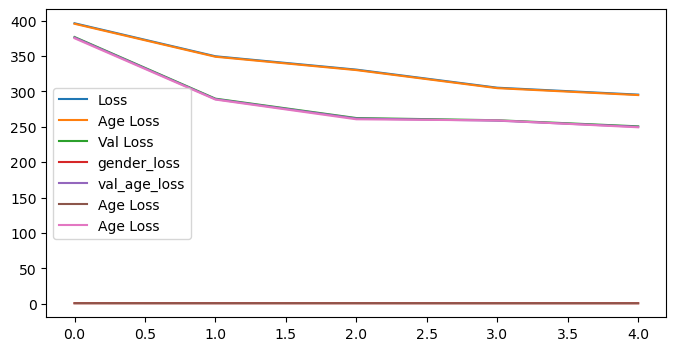

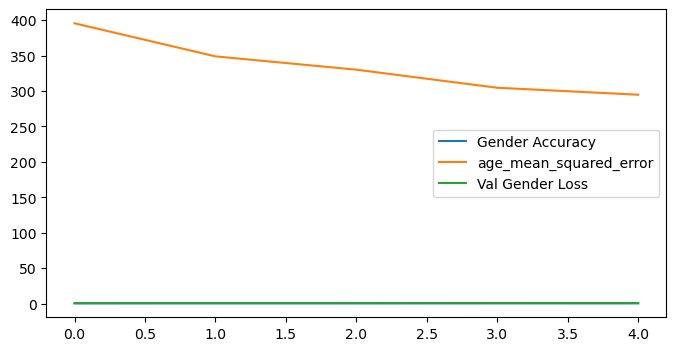

In [17]:
plt.figure(figsize=[8,4])
plt.plot(hist.history["loss"], label="Loss")
plt.plot(hist.history["age_loss"], label="Age Loss")
plt.plot(hist.history["val_loss"], label="Val Loss")
plt.plot(hist.history["gender_loss"], label="gender_loss")
plt.plot(hist.history["val_age_loss"], label="val_age_loss")
plt.plot(hist.history["val_gender_loss"], label="Age Loss")
plt.plot(hist.history["val_age_mean_squared_error"], label="Age Loss")

plt.legend()

plt.figure(figsize=[8,4])
plt.plot(hist.history["gender_accuracy"], label="Gender Accuracy")
plt.plot(hist.history["age_mean_squared_error"], label="age_mean_squared_error")
plt.plot(hist.history["val_gender_accuracy"], label="Val Gender Loss")
plt.legend()